In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from catboost import CatBoostClassifier

# Read the Data

In [3]:
working_directory = os.getcwd()
print(working_directory)
data = pd.read_csv(f"{working_directory}/Input_Data/creditcard_post_correlation.csv") #Change the path to your dataset, if needed

c:\Users\teovr\Desktop\Projects\Predicting_Fraudulent_Transactions_With_Machine_Learning


## Define Predictors and Target Variables
##### We will specify the predictor features and the target variable. Additionally, categorical features can be identified if present. In this case, there are no categorical features.



In [4]:
# Define the target variable
target = 'Fraud_Flag'

# Define the features to be used in the model
predictors = [
    'Transaction_Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
    'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
    'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',
    'Transaction_Amount'
]

## Define the TRAIN/VALIDATION/TEST SPLIT

In [5]:
#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation

RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

# Set the path to the input data
IS_LOCAL = True  # Set to True since you we running locally

if IS_LOCAL:
    PATH = (f"{working_directory}/Input_Data/")
else:
    PATH = "../input"

print(os.listdir(PATH))  # List the files in the specified directory

['creditcard.csv', 'creditcard.rar', 'creditcard_cleaned.csv', 'creditcard_post_correlation.csv', 'creditcard_post_exploration.csv', 'download_data_link.txt']


## Split data in train, test and validation set

In [6]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(
    data, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE, 
    shuffle=True
)

# Further split the training set into training and validation sets
train_df, valid_df = train_test_split(
    train_df, 
    test_size=VALID_SIZE, 
    random_state=RANDOM_STATE, 
    shuffle=True
)

## CatBoost Classifier

#### CatBoost Classifier is a gradient boosting for decision trees algorithm with support for handling categorical data.

### CatBoost Classifier definitions

In [7]:
RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NUMBER_OF_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier

### Prepare the model

In [8]:
clf3 = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = RANDOM_STATE,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = VERBOSE_EVAL,
                             od_wait=100)

In [9]:
clf3.fit(train_df[predictors], train_df[target].values,verbose=True)

0:	total: 578ms	remaining: 4m 48s
50:	total: 19.8s	remaining: 2m 54s
50:	total: 19.8s	remaining: 2m 54s
100:	total: 38.4s	remaining: 2m 31s
100:	total: 38.4s	remaining: 2m 31s
150:	total: 56.6s	remaining: 2m 10s
150:	total: 56.6s	remaining: 2m 10s
200:	total: 1m 16s	remaining: 1m 53s
200:	total: 1m 16s	remaining: 1m 53s
250:	total: 1m 35s	remaining: 1m 34s
250:	total: 1m 35s	remaining: 1m 34s
300:	total: 1m 52s	remaining: 1m 14s
300:	total: 1m 52s	remaining: 1m 14s
350:	total: 2m 10s	remaining: 55.3s
350:	total: 2m 10s	remaining: 55.3s
400:	total: 2m 27s	remaining: 36.5s
400:	total: 2m 27s	remaining: 36.5s
450:	total: 2m 45s	remaining: 18s
450:	total: 2m 45s	remaining: 18s
499:	total: 3m 2s	remaining: 0us
499:	total: 3m 2s	remaining: 0us


### Predict the target values

In [10]:
predictions3 = clf3.predict(valid_df[predictors])

### Features importance

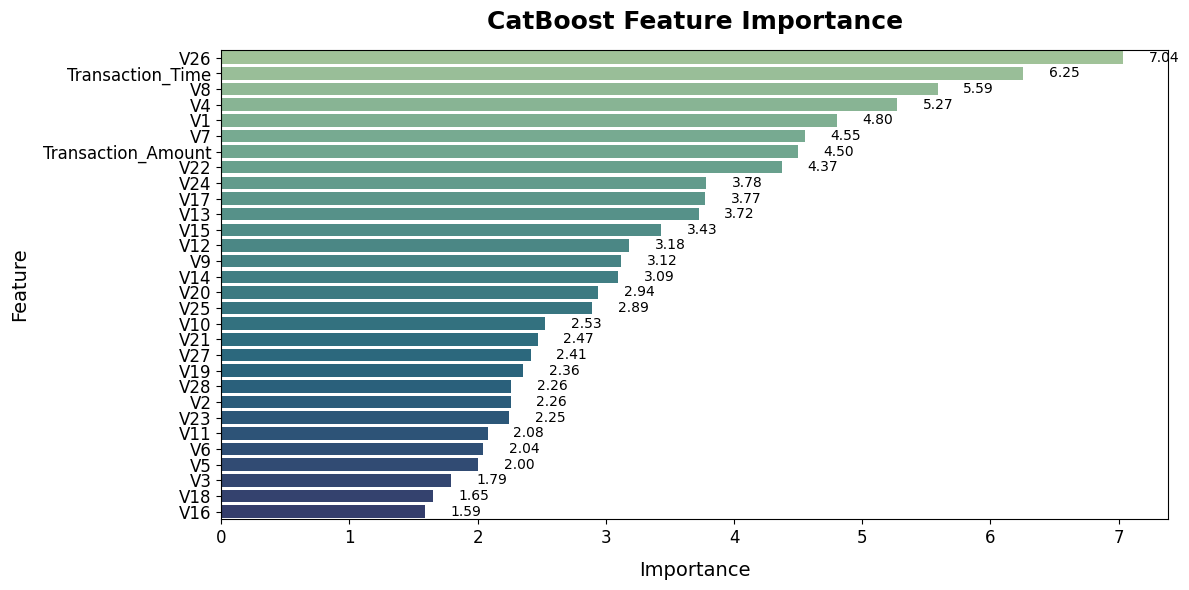

In [11]:
# Create a DataFrame for feature importance and sort it
feature_importance_df3 = pd.DataFrame({
    'Feature': predictors,
    'Importance': clf3.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importance with improved style
plt.figure(figsize=(12, 6))
plt.title('CatBoost Feature Importance', fontsize=18, fontweight='bold', pad=15)
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_df3,
    hue='Feature',          
    palette='crest',
    legend=False
)

# Add value labels to bars
for i, v in enumerate(feature_importance_df3['Importance']):
    plt.text(v + 0.2, i, f"{v:.2f}", color='black', va='center', fontsize=10)

plt.xlabel('Importance', fontsize=14, labelpad=10)
plt.ylabel('Feature', fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

### Confusion Matrix

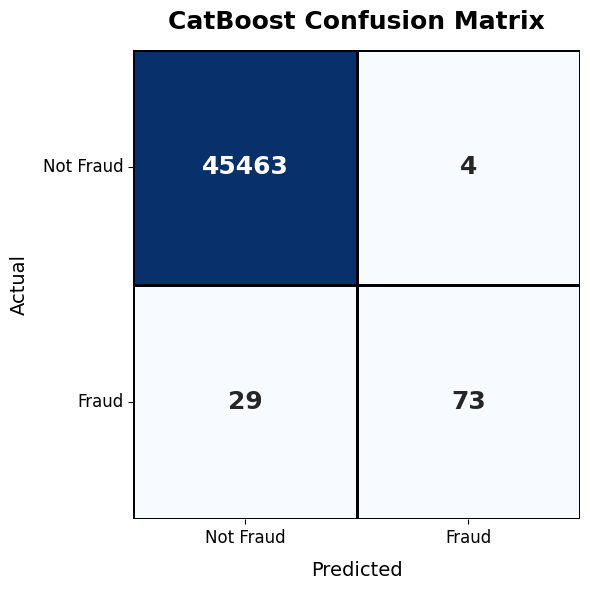

In [12]:
# Generate the confusion matrix
cm3 = pd.crosstab(
    valid_df[target].values,
    predictions3,
    rownames=['Actual'],
    colnames=['Predicted']
)

# Create a more visually appealing confusion matrix plot
plt.figure(figsize=(6, 6))
ax = sns.heatmap(
    cm3,
    annot=True,
    fmt='d',
    cmap="Blues",
    linewidths=1,
    linecolor="black",
    cbar=False,
    xticklabels=['Not Fraud', 'Fraud'],
    yticklabels=['Not Fraud', 'Fraud'],
    annot_kws={"size": 18, "weight": "bold"}
)

# Add title and axis labels
ax.set_title('CatBoost Confusion Matrix', fontsize=18, fontweight='bold', pad=15)
ax.set_xlabel('Predicted', fontsize=14, labelpad=10)
ax.set_ylabel('Actual', fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.show()

### Success Metrics

- **Accuracy**: The proportion of total predictions that were correct.
- **Precision**: The proportion of positive identifications that were actually correct (minimizes false positives).
- **Recall (Sensitivity)**: The proportion of actual positives that were correctly identified (minimizes false negatives).
- **F1 Score**: The harmonic mean of precision and recall, providing a balance between the two.
- **ROC-AUC Score**: Measures the model's ability to distinguish between classes across all thresholds. A higher ROC-AUC indicates better overall classification performance, especially important for imbalanced datasets.
- **Classification Report**: A detailed summary including precision, recall, F1-score, and support for each class.

These metrics provide a more comprehensive view of model performance, especially for imbalanced datasets like fraud detection.

In [13]:
# Calculate and print evaluation metrics
def print_metrics(y_true, y_pred, dataset_name):
    print(f"--- {dataset_name} Metrics ---")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
    print(f"ROC-AUC Score: {roc_auc_score(y_true, y_pred):.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Not Fraud", "Fraud"]))
    print("\n")

# Predictions for each set
train_pred3 = clf3.predict(train_df[predictors])
valid_pred3 = clf3.predict(valid_df[predictors])
test_pred3 = clf3.predict(test_df[predictors])

# Print metrics
print_metrics(train_df[target].values, train_pred3, "Train")
print_metrics(valid_df[target].values, valid_pred3, "Validation")
print_metrics(test_df[target].values, test_pred3, "Test")

--- Train Metrics ---
Accuracy: 0.9999
Precision: 1.0000
Recall: 0.9310
F1 Score: 0.9643
ROC-AUC Score: 0.9655

Classification Report:
               precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    181986
       Fraud       1.00      0.93      0.96       290

    accuracy                           1.00    182276
   macro avg       1.00      0.97      0.98    182276
weighted avg       1.00      1.00      1.00    182276



--- Validation Metrics ---
Accuracy: 0.9993
Precision: 0.9481
Recall: 0.7157
F1 Score: 0.8156
ROC-AUC Score: 0.8578

Classification Report:
               precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     45467
       Fraud       0.95      0.72      0.82       102

    accuracy                           1.00     45569
   macro avg       0.97      0.86      0.91     45569
weighted avg       1.00      1.00      1.00     45569



--- Test Metrics ---
Accuracy: 0.9995
Precision: 0.9625
Recall: 0

### Explanation of Evaluation Metrics

The following metrics are used to evaluate the performance of the CatBoost classifier on the fraud detection task:

- **Accuracy**: The proportion of total predictions that were correct. In imbalanced datasets, accuracy can be misleading, as a model can achieve high accuracy by simply predicting the majority class.

- **Precision**: The proportion of positive predictions (fraud) that were actually correct. High precision means that when the model predicts fraud, it is usually correct. Important when the cost of a false positive is high.

- **Recall (Sensitivity)**: The proportion of actual fraud cases that were correctly identified. High recall means the model detects most frauds. Important when missing a fraud case is costly.

- **F1 Score**: The harmonic mean of precision and recall. It balances the trade-off between precision and recall, especially useful for imbalanced datasets.

- **ROC-AUC Score**: Measures the model's ability to distinguish between classes across all thresholds. A higher ROC-AUC indicates better overall performance.

- **Classification Report**: Provides a detailed breakdown of precision, recall, F1-score, and support for each class (fraud and not fraud).

**Note:** In fraud detection, recall and ROC-AUC are often prioritized, as it is crucial to identify as many fraudulent transactions as possible, even if it means accepting some false positives.